In [1]:
import torch
import torchvision
from torchsummary import summary
import warnings
# Suppress FutureWarning specifically from torch.load
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

################### GPU ##########################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(device.index)  # Set the device explicitly
    print(torch.cuda.current_device())  # Should print 1 if cuda:1 is active

if torch.backends.cudnn.is_available()==True:
    print('CUDNN is available! ')
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

try:
    import torch_directml
    device = torch_directml.device()
    print("DirectML is available, using DirectML")
except:
    print("DirectML is not available, using CPU/GPU")

##################################################

import windturbine_final as wt

0
CUDNN is available! 
DirectML is not available, using CPU/GPU


In [2]:
ResNet34 = torchvision.models.resnet34(weights=None)
ResNet34.fc = torch.nn.Linear(in_features=512,out_features=2,bias=True)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34.to(device)

#summary(model, input_size=(3, 350, 350), device=device.type)

In [3]:
def transform(image):
    image = np.array(image)
    image = image[200:550,465:815]
    
    # Convert back to PIL Image for further transforms
    image = Image.fromarray(image)
    
    # Compose transformations
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
    ])
    return transform(image)

def transform_all_noise(image):
    # Get either 0 or 1
    noise = np.random.randint(0, 2)
    if noise == 0:
        # Get 2 random numbers between -50 and 50
        x,y = np.random.normal(0, 15, 2).astype(int)

        # Convert image to array
        image = np.array(image)
        image = image[200+x:550+x,465+y:815+y]

        # Convert back to PIL Image for further transforms
        image = Image.fromarray(image)

        # Compose transformations
        transform = transforms.Compose([
            transforms.ToTensor(),  # Convert to tensor
        ])
    else:
        x = np.random.randint(400, 600)
        transform = transforms.Compose([
            transforms.CenterCrop(x),
            transforms.Resize(350),
            transforms.ToTensor(),
        ])
    return transform(image)

def transform_normal_noise(image):
    # Get 2 random numbers between -50 and 50
    x,y = np.random.normal(0, 15, 2).astype(int)

    # Convert image to array
    image = np.array(image)
    image = image[200+x:550+x,465+y:815+y]

    # Convert back to PIL Image for further transforms
    image = Image.fromarray(image)

    # Compose transformations
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
    ])
    return transform(image)


### Parameters ResNet34

In [4]:
angle_type = "both"
batch_size = 64
images_num = 1
model = ResNet34
lr = 1e-2
epochs = 40
accu_th = [5,2,1,0.5,0.1]
model_name = "final_models/ResNet34_30deg_RnD.pth"

wind_dataset = wt.WindTurbineDataset(csv_file='rotations_w_images_long_30_deg.csv', root_dir='data/', 
                                     images_num=images_num, transform=transform, angle_type=angle_type)
print(f"Dataset size: {len(wind_dataset)}")

train_dataset, test_dataset = wt.WindTurbineDataloader.train_test_split(wind_dataset, test_size=0.2)
trainloader = wt.WindTurbineDataloader.dataloader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = wt.WindTurbineDataloader.dataloader(test_dataset, batch_size=batch_size, shuffle=True)

try:
    model.load_state_dict(torch.load(model_name, map_location=torch.device("cpu")))
    print("Model loaded successfully")
    lr = 1e-4
    epochs = 20
except:
    print("Model not found, training from scratch")
model = model.to(device)

# Loss function
criterion = wt.modLoss(n_input=2, bias=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#Scheduler
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=np.sqrt(0.1), patience=2, threshold=0.0001)

#Trainer
trainer = wt.Trainer(model, trainloader, testloader, criterion, optimizer,device, 
                     epochs=epochs, accu_th=accu_th, angle_type=angle_type, 
                     schedular=schedular, minimal=False)


Dataset size: 5997
Model not found, training from scratch


### ResNet34 Model Training

Epoch 1/40, Train Loss: 0.1026, Test Loss: 0.167
lr [0.01]
Angle            5.00  2.00  1.00  0.50  0.10   5.00   2.00  1.00  0.50  0.10
Train Accuracy  16.53  6.69  3.40  1.56  0.25  30.85  12.77  6.88  3.42  0.51
Test Accuracy   19.18  7.81  3.73  2.08  0.52  11.02   4.08  2.08  1.04  0.09
Epoch 2/40, Train Loss: 0.0536, Test Loss: 0.0881
lr [0.01]
Angle            5.00   2.00  1.00  0.50  0.10   5.00   2.00  1.00  0.50  0.10
Train Accuracy  26.69  10.56  5.36  2.85  0.44  44.32  18.45  9.10  4.46  0.82
Test Accuracy   20.49   7.81  4.34  1.82  0.43  33.33  14.15  7.81  3.73  0.95
Epoch 3/40, Train Loss: 0.0654, Test Loss: 0.3171
lr [0.01]
Angle            5.00   2.00  1.00  0.50  0.10   5.00   2.00  1.00  0.50  0.10
Train Accuracy  26.71  10.87  5.51  2.58  0.49  39.61  16.34  7.73  3.78  0.65
Test Accuracy    1.82   0.69  0.43  0.35  0.00   6.68   2.43  0.95  0.52  0.00
Epoch 4/40, Train Loss: 0.0531, Test Loss: 0.0555
lr [0.01]
Angle            5.00   2.00  1.00  0.50  0.10   5.00

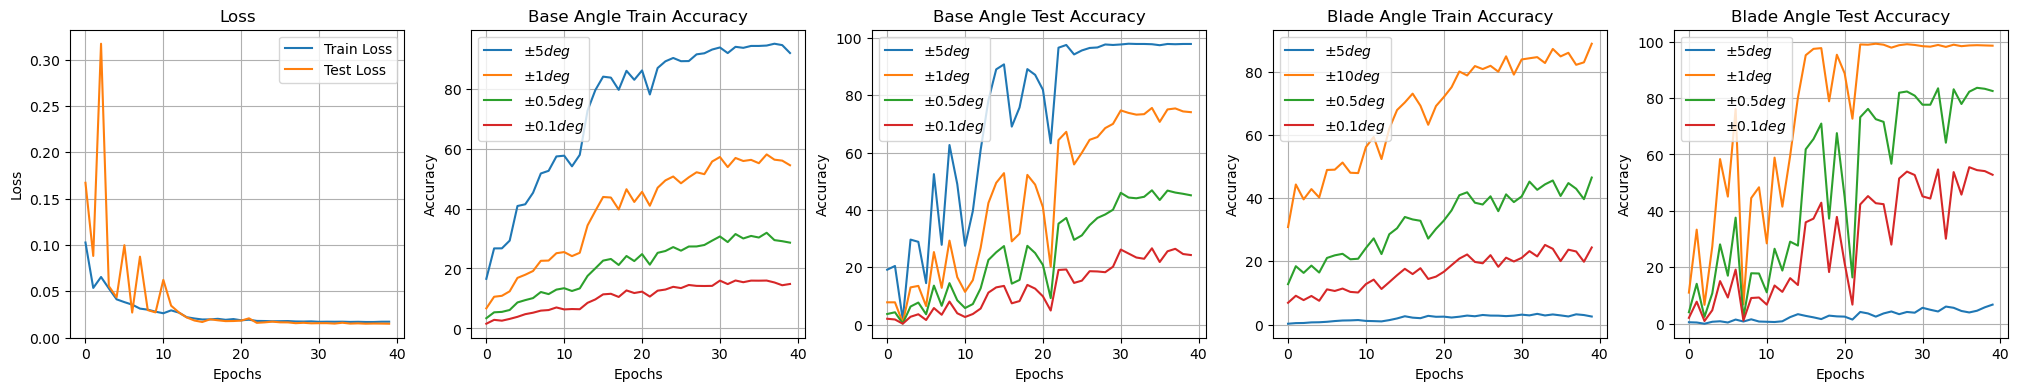

In [5]:
model = trainer.train_model()

# Plot the training and testing loss
plt.figure(figsize=(25, 4))
# Make subplot with loss and accuracy
plt.subplot(1, 5, 1)
plt.plot(trainer.train_loss, label="Train Loss")
plt.plot(trainer.test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.grid()
if not trainer.minimal:
    # Make subplot with loss and accuracy
    plt.subplot(1, 5, 2)
    plt.title("Base Angle Train Accuracy")
    plt.plot(trainer.train_accuracy[:,0], label=r"$\pm 5deg$")
    plt.plot(trainer.train_accuracy[:,1], label=r"$\pm 1deg$")
    plt.plot(trainer.train_accuracy[:,2], label=r"$\pm 0.5deg$")
    plt.plot(trainer.train_accuracy[:,3], label=r"$\pm 0.1deg$")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 5, 3)
    plt.title("Base Angle Test Accuracy")
    plt.plot(trainer.test_accuracy[:,0], label=r"$\pm 5deg$")
    plt.plot(trainer.test_accuracy[:,1], label=r"$\pm 1deg$")
    plt.plot(trainer.test_accuracy[:,2], label=r"$\pm 0.5deg$")
    plt.plot(trainer.test_accuracy[:,3], label=r"$\pm 0.1deg$")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 5, 4)
    plt.title("Blade Angle Train Accuracy")
    plt.plot(trainer.train_accuracy[:,4], label=r"$\pm 5deg$")
    plt.plot(trainer.train_accuracy[:,5], label=r"$\pm 10deg$")
    plt.plot(trainer.train_accuracy[:,6], label=r"$\pm 0.5deg$")
    plt.plot(trainer.train_accuracy[:,7], label=r"$\pm 0.1deg$")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 5, 5)
    plt.title("Blade Angle Test Accuracy")
    plt.plot(trainer.test_accuracy[:,4], label=r"$\pm 5deg$")
    plt.plot(trainer.test_accuracy[:,5], label=r"$\pm 1deg$")
    plt.plot(trainer.test_accuracy[:,6], label=r"$\pm 0.5deg$")
    plt.plot(trainer.test_accuracy[:,7], label=r"$\pm 0.1deg$")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
plt.show()

### Save Model

In [6]:
torch.save(model.to("cpu").state_dict(), model_name)
print("Model saved successfully")

Model saved successfully


### Test Model

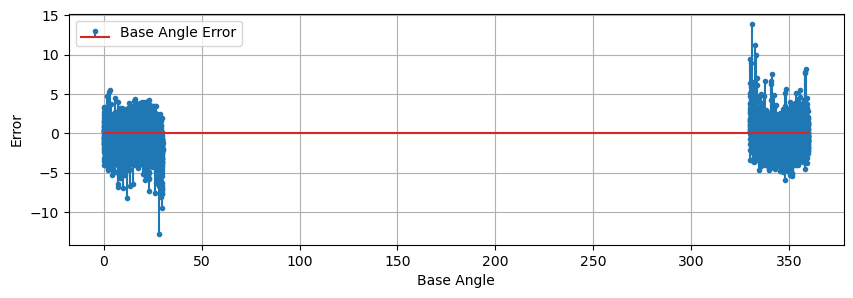

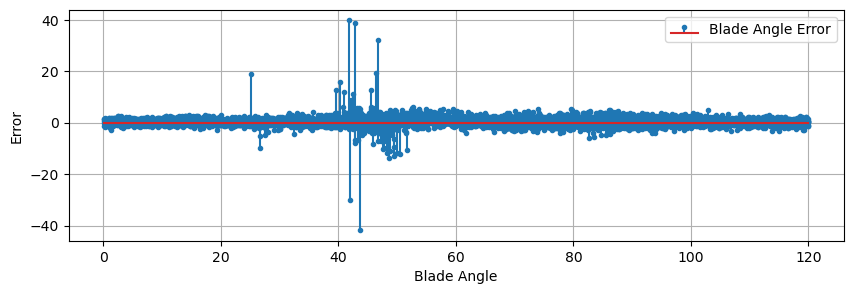

In [7]:
# Test the model
results = trainer.test_model(model.to(device), wind_dataset, angle_type=angle_type)
# Sort the results by base angle
results_sorted = results.sort_values(by="Base_Angle")

# Plot the results
if angle_type == "both" or angle_type == "base_angle":
    plt.figure(figsize=(10, 3))
    plt.stem(results_sorted["Base_Angle"], results_sorted["Base_Angle_Error"], label="Base Angle Error",markerfmt='.')
    plt.xlabel("Base Angle")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.show()
if angle_type == "both" or angle_type == "blade_angle":
    plt.figure(figsize=(10, 3))
    plt.stem(results_sorted["Blade_Angle"], results_sorted["Blade_Angle_Error"], label="Blade Angle Error", markerfmt='.')
    plt.xlabel("Blade Angle")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.show()